In [99]:
import torch
import tqdm
import torch.nn.functional as F

import matplotlib.pyplot as plt

from hydra import initialize, compose
from hydra.utils import instantiate
import pytorch_lightning

from bliss.surveys.dc2 import DC2DataModule, calculate_blendedness
from bliss.catalog import TileCatalog

In [ ]:
with initialize(config_path="./", version_base=None):
    notebook_cfg = compose("notebook_config")

In [101]:
seed = 7272
pytorch_lightning.seed_everything(seed=seed)

Seed set to 7272


7272

In [ ]:
tile_slen = notebook_cfg.surveys.dc2.tile_slen
max_sources_per_tile = notebook_cfg.surveys.dc2.max_sources_per_tile
r_band_min_flux = notebook_cfg.notebook_var.r_band_min_flux

batch_size = 800
dc2: DC2DataModule = instantiate(notebook_cfg.surveys.dc2)
dc2.batch_size = batch_size
dc2.setup(stage="validate")
dc2_val_dataloader = dc2.val_dataloader()

In [ ]:
n_sources_list = []
ori_blendedness = []
new_blendedness = []
for one_batch in tqdm.tqdm(dc2_val_dataloader):
    target_full_cat = TileCatalog(one_batch["tile_catalog"]).get_brightest_sources_per_tile(band=2).to_full_catalog(tile_slen=4)
    target_full_cat["new_blendedness"] = calculate_blendedness(target_full_cat, 30.0, brute_force=True, weight_std=6.0)
    target_tile_cat = target_full_cat.to_tile_catalog(tile_slen=4, max_sources_per_tile=1)
    n_sources_list.append((target_tile_cat["n_sources"] > 0) & ~(target_tile_cat["blendedness"].isnan()).squeeze())
    ori_blendedness.append(target_tile_cat["blendedness"])
    new_blendedness.append(target_tile_cat["new_blendedness"])
n_sources_list = torch.cat(n_sources_list, dim=0)
ori_blendedness = torch.cat(ori_blendedness, dim=0)
new_blendedness = torch.cat(new_blendedness, dim=0)

100%|██████████| 32/32 [00:46<00:00,  1.46s/it]


In [ ]:
n_sources_list.shape, ori_blendedness.shape, new_blendedness.shape

(torch.Size([25000, 20, 20]),
 torch.Size([25000, 20, 20, 1, 1]),
 torch.Size([25000, 20, 20, 1, 1]))

In [ ]:
ori_blendedness = ori_blendedness.squeeze()
new_blendedness = new_blendedness.squeeze()

In [ ]:
ori_blendedness.shape, new_blendedness.shape

(torch.Size([25000, 20, 20]), torch.Size([25000, 20, 20]))

In [ ]:
ori_blendedness = ori_blendedness[n_sources_list]
new_blendedness = new_blendedness[n_sources_list]

In [ ]:
ori_blendedness.shape, new_blendedness.shape

(torch.Size([139609]), torch.Size([139609]))

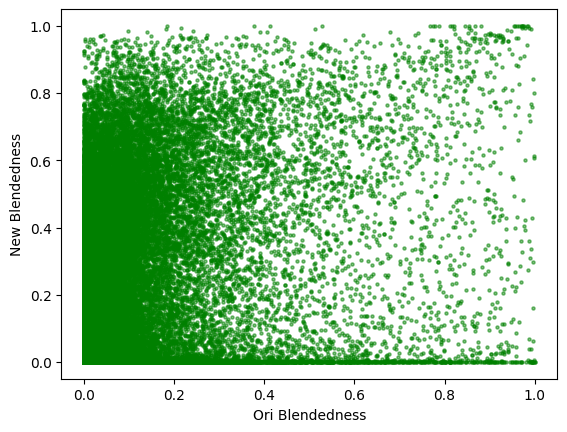

In [ ]:
plt.scatter(ori_blendedness, new_blendedness, s=5, alpha=0.5, c="green")
plt.xlabel("Ori Blendedness")
plt.ylabel("New Blendedness")
plt.show()

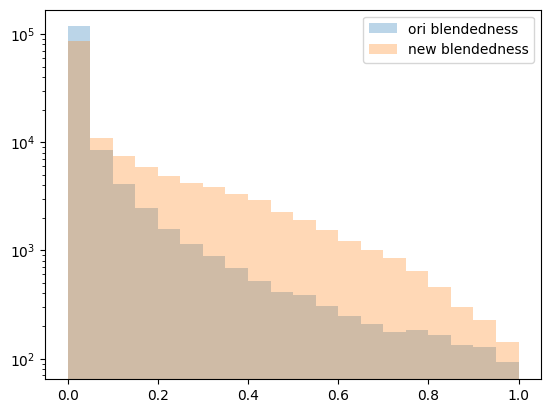

In [ ]:
plt.hist(ori_blendedness, bins=20, density=False, log=True, alpha=0.3, label="ori blendedness")
plt.hist(new_blendedness, bins=20, density=False, log=True, alpha=0.3, label="new blendedness")
plt.legend()
plt.show()

In [ ]:
bin_cutoffs = torch.tensor([0.02, 0.3, 0.5, 0.7, 0.9])
print(torch.bincount(torch.bucketize(ori_blendedness, bin_cutoffs)))
print(torch.bincount(torch.bucketize(new_blendedness, bin_cutoffs)))

tensor([104899,  30184,   2498,   1149,    658,    221])
tensor([73891, 45057, 12352,  5686,  2257,   366])


In [ ]:
torch.corrcoef(torch.stack([ori_blendedness, new_blendedness], dim=0))

tensor([[1.0000, 0.4199],
        [0.4199, 1.0000]])

In [113]:
dc2_val_dataloader = dc2.val_dataloader()

In [114]:
low_bl_pixel_values = []
low_bl_pixel_fluxes = []
high_bl_pixel_values = []
high_bl_pixel_fluxes = []
for one_batch in tqdm.tqdm(dc2_val_dataloader):
    ori_image = one_batch["images"]  # (b, bands, h, w)
    images = F.max_pool2d(ori_image, kernel_size=5, stride=1, padding=2)
    images = one_batch["images"].permute(0, 2, 3, 1)  # (b, h, w, bands)
    target_full_cat = TileCatalog(one_batch["tile_catalog"]).to_full_catalog(tile_slen=4)
    target_tile_cat = target_full_cat.to_tile_catalog(tile_slen=1, max_sources_per_tile=2).get_brightest_sources_per_tile()
    low_bl_mask = (target_tile_cat["blendedness"] < 1e-6).squeeze() & \
                        ~(target_tile_cat["blendedness"].isnan()).squeeze() & \
                        target_tile_cat.is_on_mask.squeeze()  # (b, h, w)
    low_bl_pixel_values.append(images[low_bl_mask])  # (N, bands)
    low_bl_pixel_fluxes.append(target_tile_cat["fluxes"].squeeze(-2)[low_bl_mask])  # (N, bands)
    high_bl_mask = (target_tile_cat["blendedness"] > 0.5).squeeze() & \
                        ~(target_tile_cat["blendedness"].isnan()).squeeze() & \
                        target_tile_cat.is_on_mask.squeeze()  # (b, h, w)
    high_bl_pixel_values.append(images[high_bl_mask])  # (N, bands)
    high_bl_pixel_fluxes.append(target_tile_cat["fluxes"].squeeze(-2)[high_bl_mask])  # (N, bands)
low_bl_pixel_values = torch.cat(low_bl_pixel_values, dim=0)
low_bl_pixel_fluxes = torch.cat(low_bl_pixel_fluxes, dim=0)
high_bl_pixel_values = torch.cat(high_bl_pixel_values, dim=0)
high_bl_pixel_fluxes = torch.cat(high_bl_pixel_fluxes, dim=0)

100%|██████████| 32/32 [02:05<00:00,  3.93s/it]


In [115]:
images.max(), images.min()

(tensor(2331.4602), tensor(-1.2782))

In [116]:
low_bl_pixel_fluxes.shape, low_bl_pixel_values.shape

(torch.Size([43819, 6]), torch.Size([43819, 6]))

In [117]:
high_bl_pixel_fluxes.shape, high_bl_pixel_values.shape

(torch.Size([2031, 6]), torch.Size([2031, 6]))

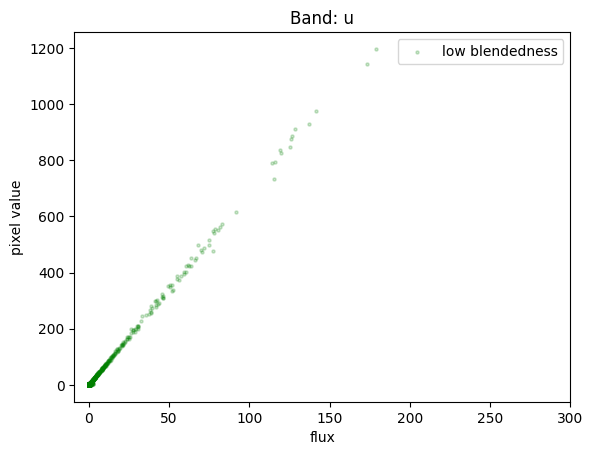

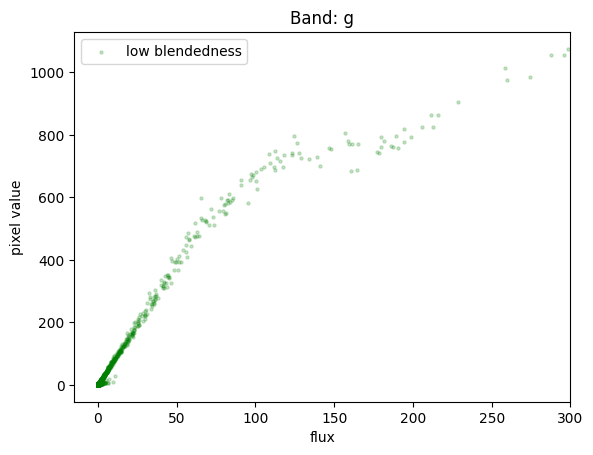

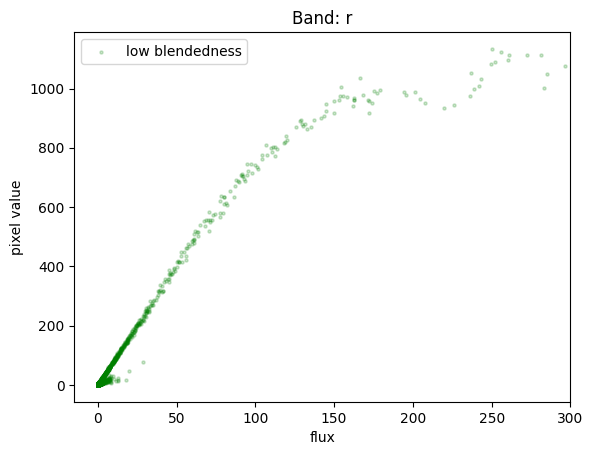

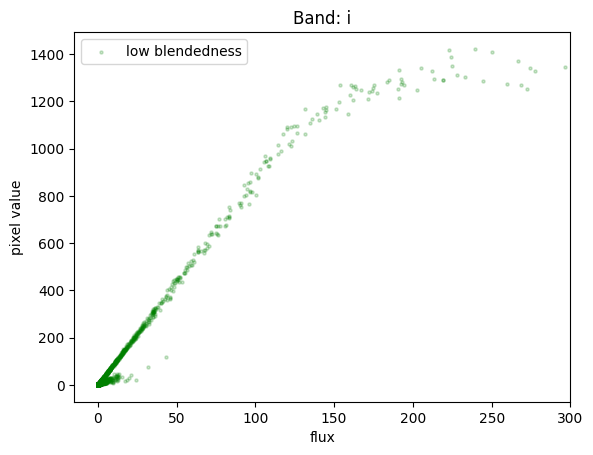

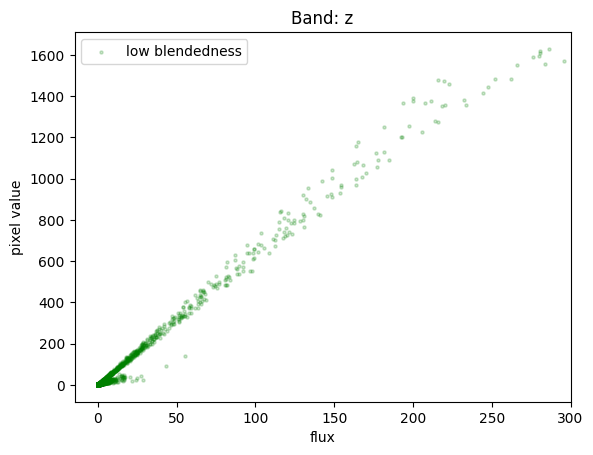

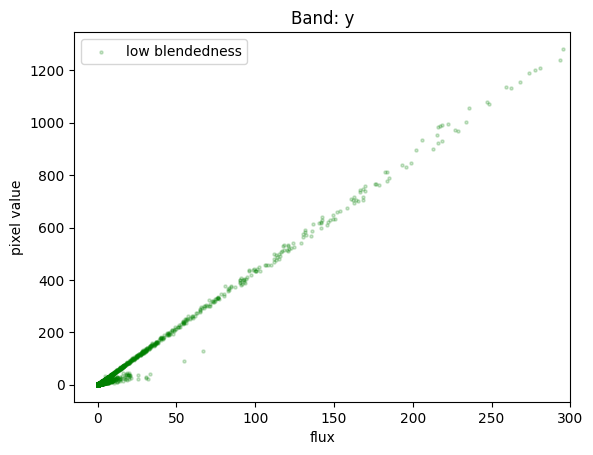

In [118]:
for i, band_name in enumerate("ugrizy"):
    flux_mask = (low_bl_pixel_fluxes[:, i] / 10_000) < 300
    plt.scatter(low_bl_pixel_fluxes[flux_mask, i] / 10_000, 
                low_bl_pixel_values[flux_mask, i], 
                s=5, c="green", alpha=0.2,
                label="low blendedness")
    plt.xlabel("flux")
    plt.ylabel("pixel value")
    plt.xlim(right=300)
    plt.title(f"Band: {band_name}")
    plt.legend()
    plt.show()

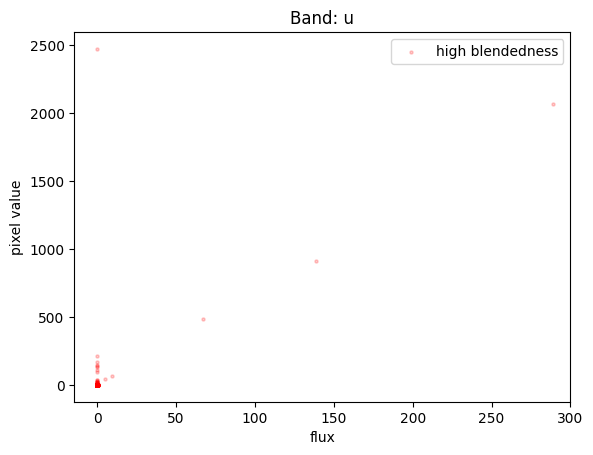

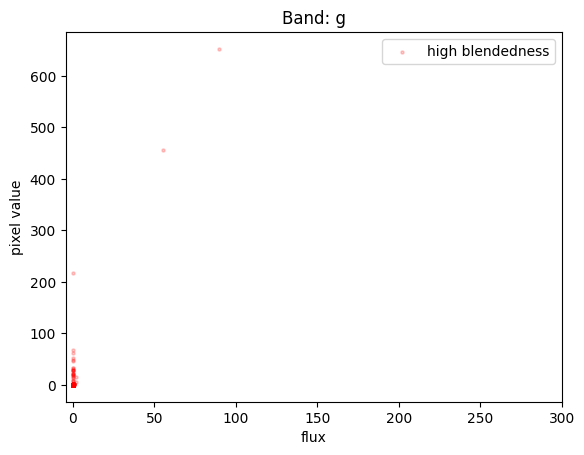

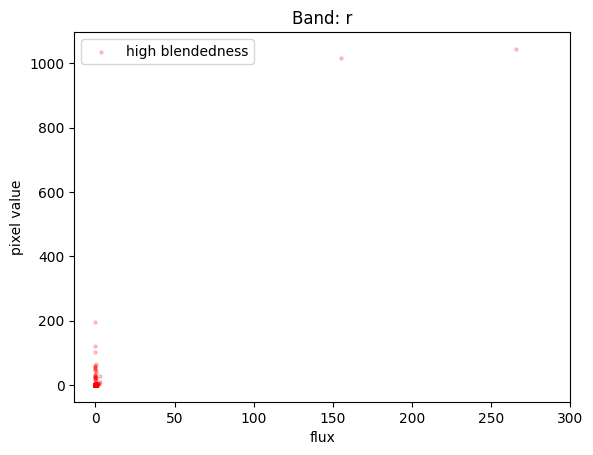

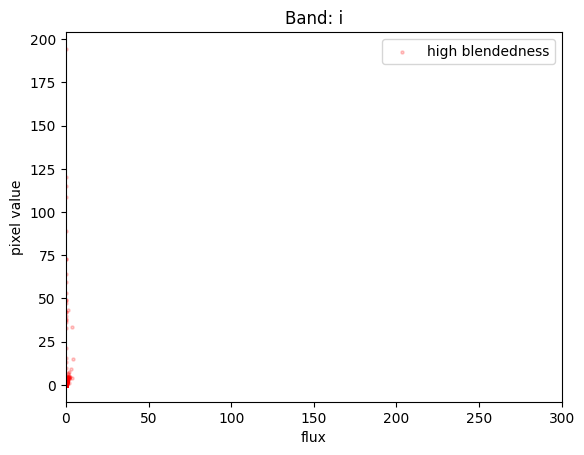

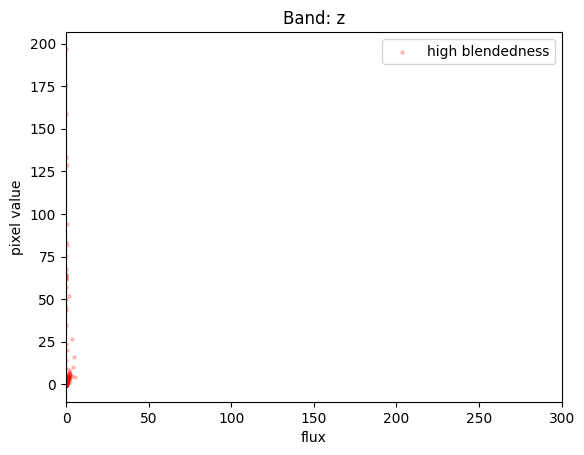

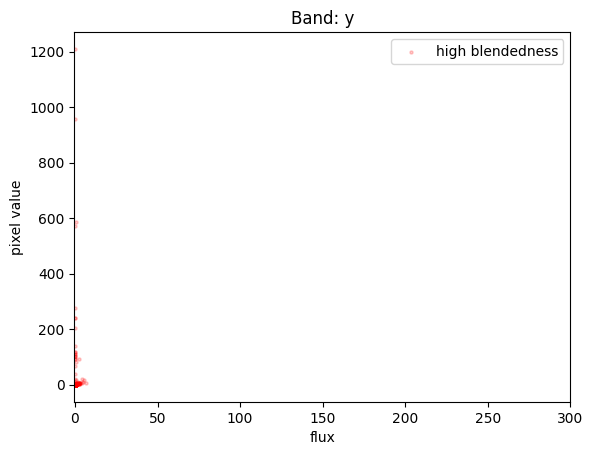

In [119]:
for i, band_name in enumerate("ugrizy"):
    flux_mask = (high_bl_pixel_fluxes[:, i] / 10_000) < 300
    plt.scatter(high_bl_pixel_fluxes[flux_mask, i] / 10_000,
                high_bl_pixel_values[flux_mask, i],
                s=5, c="red", alpha=0.2,
                label="high blendedness")
    plt.xlabel("flux")
    plt.xlim(right=300)
    plt.ylabel("pixel value")
    plt.title(f"Band: {band_name}")
    plt.legend()
    plt.show()

In [120]:
def get_ols(fluxes, values):
    A = torch.stack([fluxes, torch.ones_like(fluxes)], dim=-1)
    B = values.unsqueeze(1)
    slope, intercept = torch.linalg.lstsq(A, B).solution.chunk(2, dim=0)
    return slope.squeeze(-1), intercept.squeeze(-1)

Band u ols coeff: 6.833721638; -0.061386723


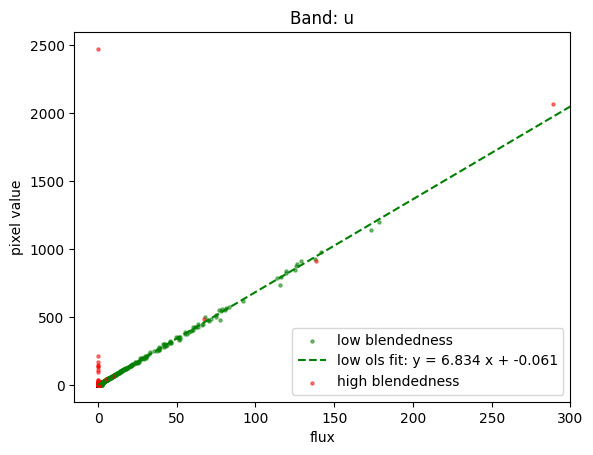

Band g ols coeff: 7.443443298; -0.071975365


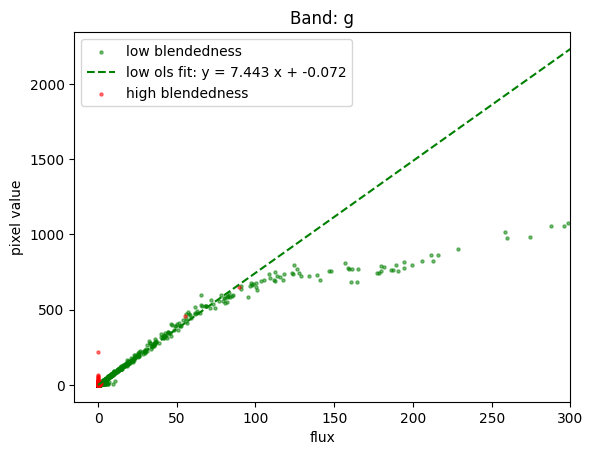

Band r ols coeff: 7.782284260; -0.205841884


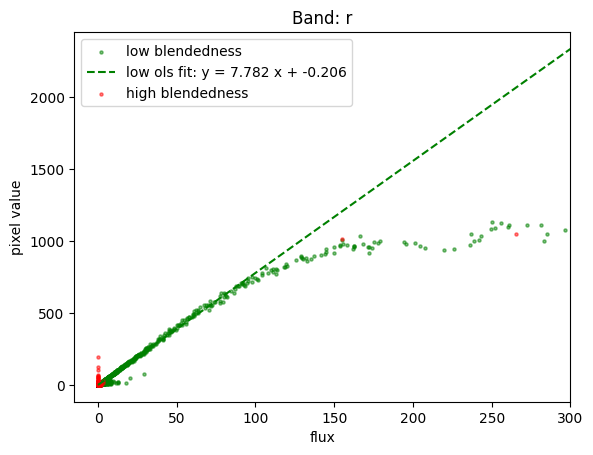

Band i ols coeff: 8.532368660; -0.399775535


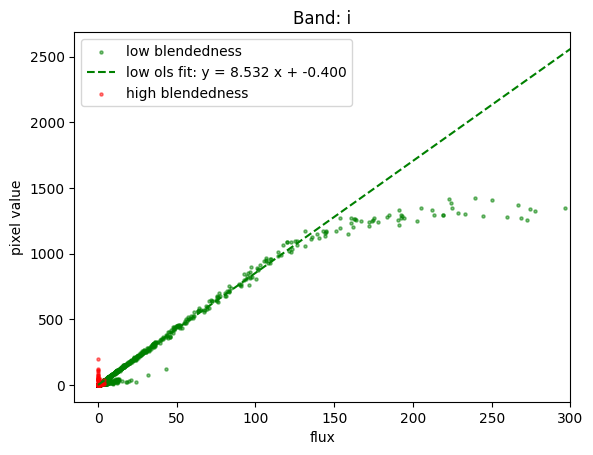

Band z ols coeff: 6.306288242; -0.348405063


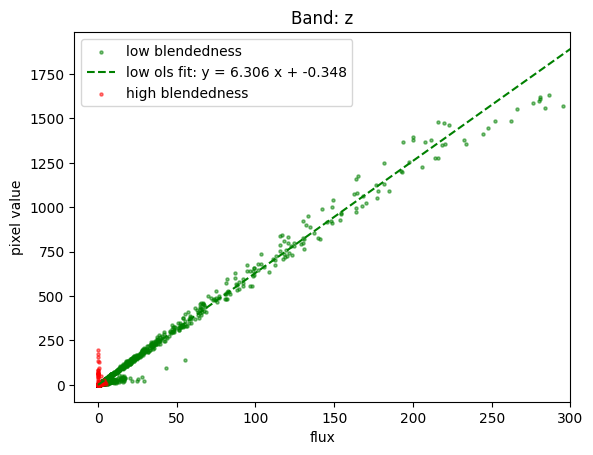

Band y ols coeff: 4.226921082; -0.200793356


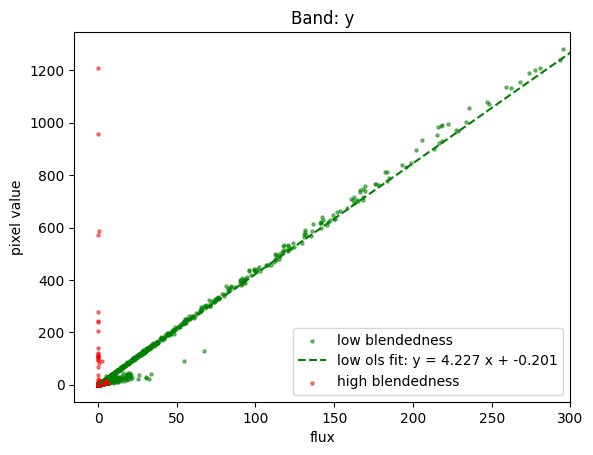

In [121]:
for i, band_name in enumerate("ugrizy"):
    flux_mask = (low_bl_pixel_fluxes[:, i] / 10_000) < 300
    plt.scatter(low_bl_pixel_fluxes[flux_mask, i] / 10_000, 
                low_bl_pixel_values[flux_mask, i], 
                s=5, c="green", alpha=0.5,
                label="low blendedness")
    strict_flux_mask = (low_bl_pixel_fluxes[:, i] / 10_000) < 100
    low_s, low_i = get_ols(low_bl_pixel_fluxes[strict_flux_mask, i] / 10_000, 
                           low_bl_pixel_values[strict_flux_mask, i])
    low_x_fit = torch.linspace(0, 300, 100)
    low_y_fit = low_s * low_x_fit + low_i
    plt.plot(low_x_fit, low_y_fit, 
             color="green", linestyle="dashed",
             label=f"low ols fit: y = {low_s.item():.3f} x + {low_i.item():.3f}")
    print(f"Band {band_name} ols coeff: {low_s.item():.9f}; {low_i.item():.9f}")

    flux_mask = (high_bl_pixel_fluxes[:, i] / 10_000) < 300
    plt.scatter(high_bl_pixel_fluxes[flux_mask, i] / 10_000,
                high_bl_pixel_values[flux_mask, i],
                s=5, c="red", alpha=0.5,
                label="high blendedness")
    plt.xlabel("flux")
    plt.xlim(right=300)
    plt.ylabel("pixel value")
    plt.title(f"Band: {band_name}")
    plt.legend()
    plt.show()